In exploratory data analysis, we are just getting to understand our dataset better (distributions, categories etc). Since we are not performing any sort of preprocessing, we can just use the entire dataset for EDA. We will split the data into train, test and split later on when we are preprocessing the data

In [5]:
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from stroke_prediction.config import settings

# 1. Import Data

In [6]:
# Read data
df = pd.read_csv(Path(settings.DATASET_DIR, "train.csv"))

# Drop index
df.drop('id', axis=1, inplace=True)

In [41]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


# 2. Missing Values

There are no missing values

In [7]:
def missing_values_summary(df):
    """
    Returns a summary table showing null value counts and percentage
    
    Parameters:
    df (DataFrame): Dataframe to check
    
    Returns:
    null_values (DataFrame)
    """
    null_values = pd.DataFrame(df.isnull().sum())
    null_values[1] = null_values[0]/len(df)
    null_values.columns = ['Count','Percentage']
    return null_values

In [8]:
missing_values_summary(df)

,Count,Percentage
gender,0,0.0
age,0,0.0
hypertension,0,0.0
heart_disease,0,0.0
ever_married,0,0.0
work_type,0,0.0
Residence_type,0,0.0
avg_glucose_level,0,0.0
bmi,0,0.0
smoking_status,0,0.0


# 3. Data Type

In [9]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [10]:
# Categorical Variables
cat_vars = [var for var in df.columns if df[var].dtype == 'object']

# Discrete Variables
discrete_vars = ['hypertension', 'heart_disease']

# Target Variable
target_var = ['stroke']

# Numerical Variables
num_vars = [var for var in df.columns if df[var].dtype == 'float']

In [11]:
cat_vars

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [12]:
discrete_vars

['hypertension', 'heart_disease']

In [13]:
target_var

['stroke']

In [14]:
num_vars

['age', 'avg_glucose_level', 'bmi']

# 4. Variables Exploration

### 4.1 Target Variable

https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-dataset

Very imbalance dataset. We have about 96% class 0 and 4% class 1 observations. We will have to use metrics that account for the imbalanced dataset.
- F1 Score
- Precision (positive class more important)
- Recall
- AUC ROC Score (both classes important)

For this dataset, it is more costly to label someone as negative when they are in fact positive. (false negative more costly, want to maximize recall)

In [15]:
df.stroke.value_counts()/len(df)

stroke
0    0.958704
1    0.041296
Name: count, dtype: float64

<Axes: xlabel='stroke', ylabel='count'>

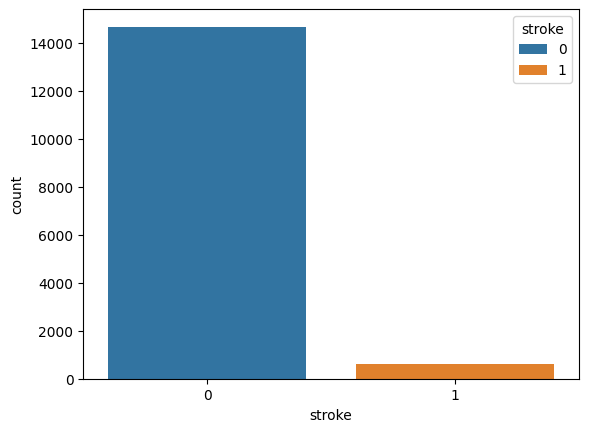

In [16]:
sns.countplot(data=df, x='stroke', hue='stroke')

### 4.2 Continuous Variables

Let's look at the relationship between the continuous variables and the target variable

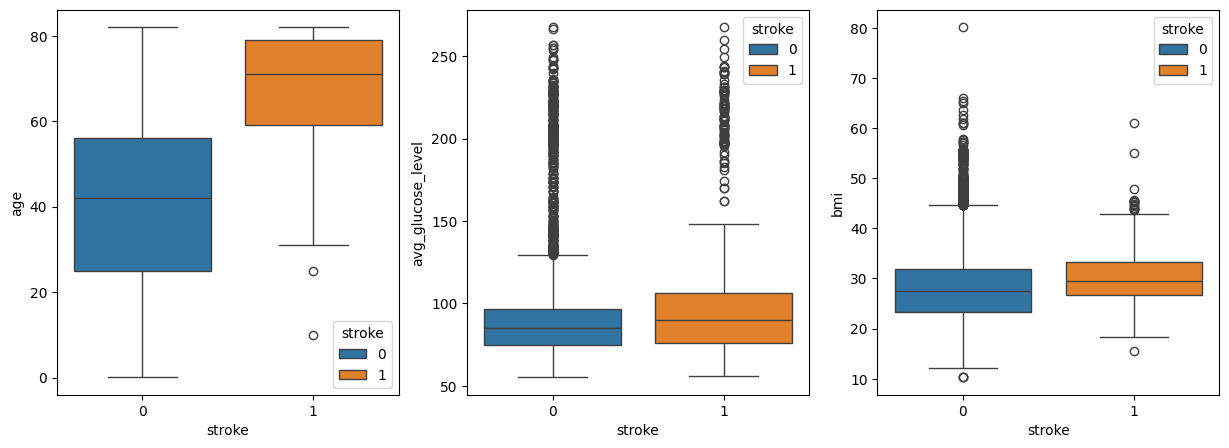

In [17]:
fix, ax = plt.subplots(1,3, figsize=(15,5))
for index, var_name in enumerate(num_vars):
    col = index % 3
    sns.boxplot(x="stroke", y=var_name, data=df, hue='stroke', ax=ax[col])

In [18]:
def plot_dist_separate_numeric_cols(df, numeric_columns):
    xaxes = numeric_columns

    positive_class = df.query("stroke == 1")
    negative_class = df.query("stroke == 0")

    f, axes = plt.subplots(len(numeric_columns),2, figsize=(15,20))

    for idx, ax in enumerate(xaxes):
        if (idx != 5):
            sns.histplot(ax=axes[idx, 0], data=negative_class, x=xaxes[idx], kde=True, color='green')
            axes[idx, 0].set_title("Stroke == 0")

            sns.histplot(ax=axes[idx, 1], data=positive_class, x=xaxes[idx], kde=True, color='red')
            axes[idx, 1].set_title("Stroke == 1")

    #f.suptitle(title, fontsize=15)
    plt.show()

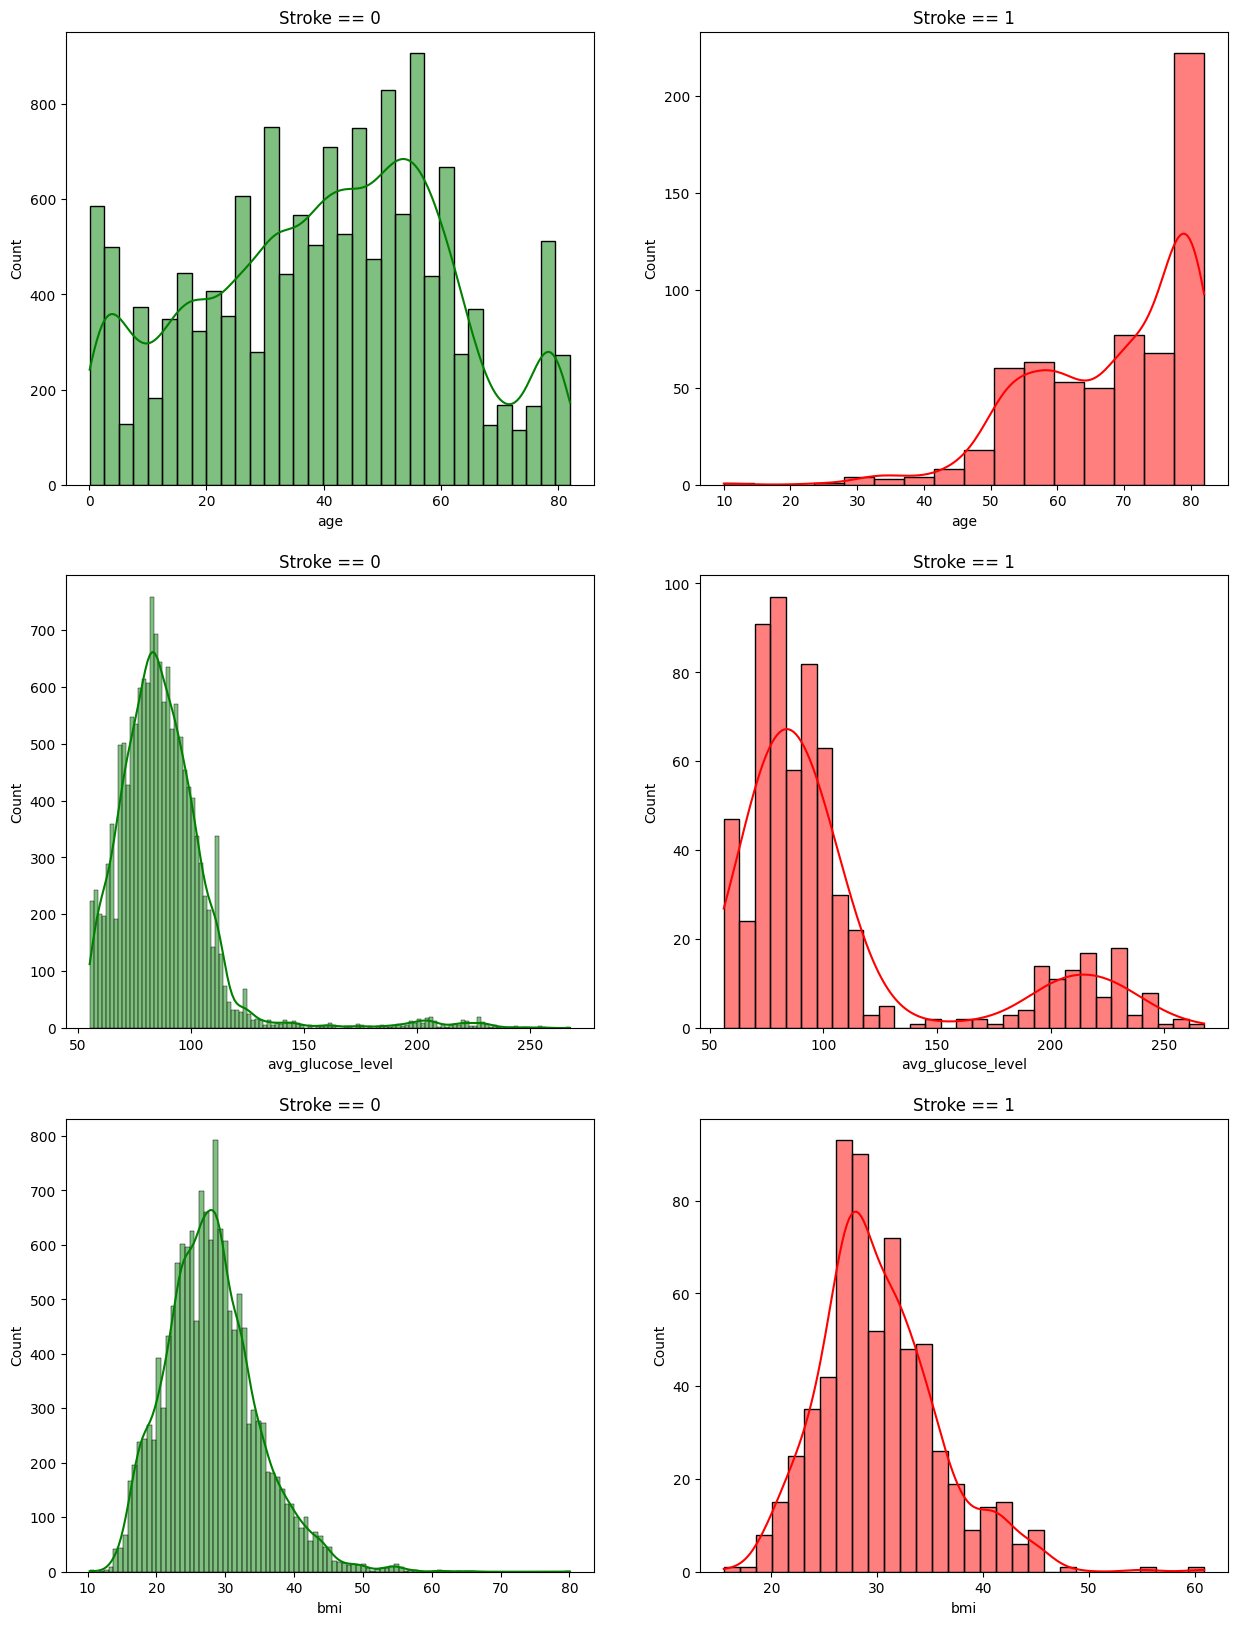

In [19]:
plot_dist_separate_numeric_cols(df, num_vars)

- Based on the ``age`` variable, older people are more susceptible to stroke
- Based on the ``avg_glucose_level`` and ``bmi`` variable, there is not much difference in the distribution between people who has stroke and no stroke


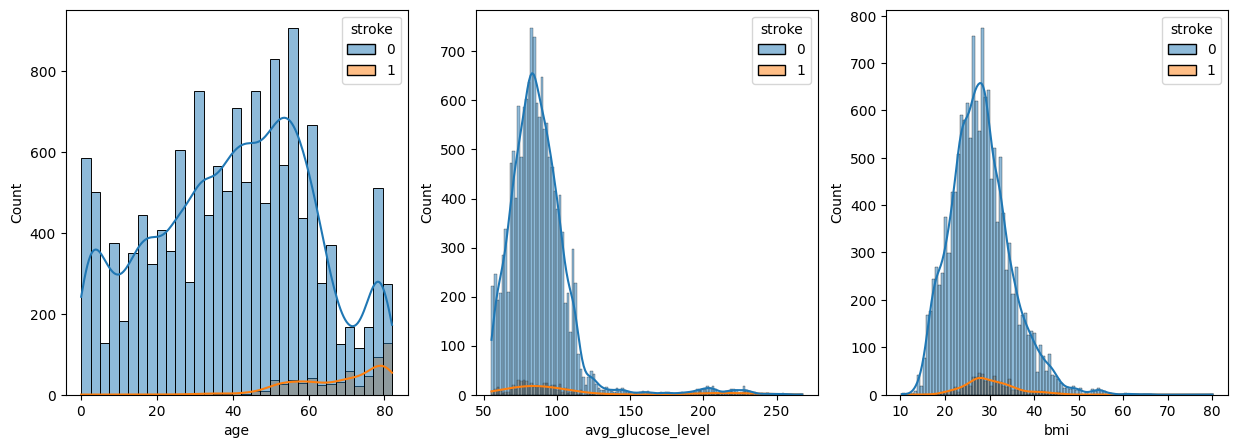

In [20]:
fix, ax = plt.subplots(1, 3, figsize=(15, 5))
for index, var_name in enumerate(num_vars):
    col = index % 3
    sns.histplot(x=var_name, data=df, hue='stroke', kde=True, ax=ax[col])

The continuous variables does not have a strong correlation with each other

<Axes: >

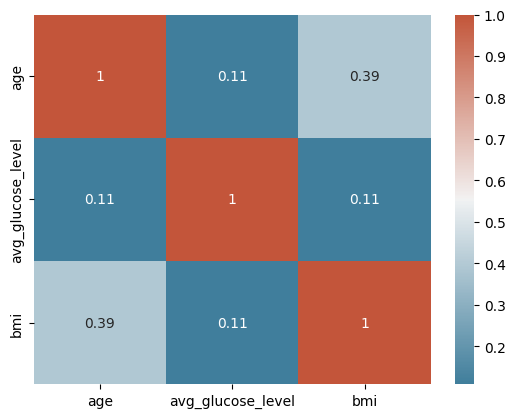

In [21]:
corr = df.loc[:,num_vars].corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, annot=True)

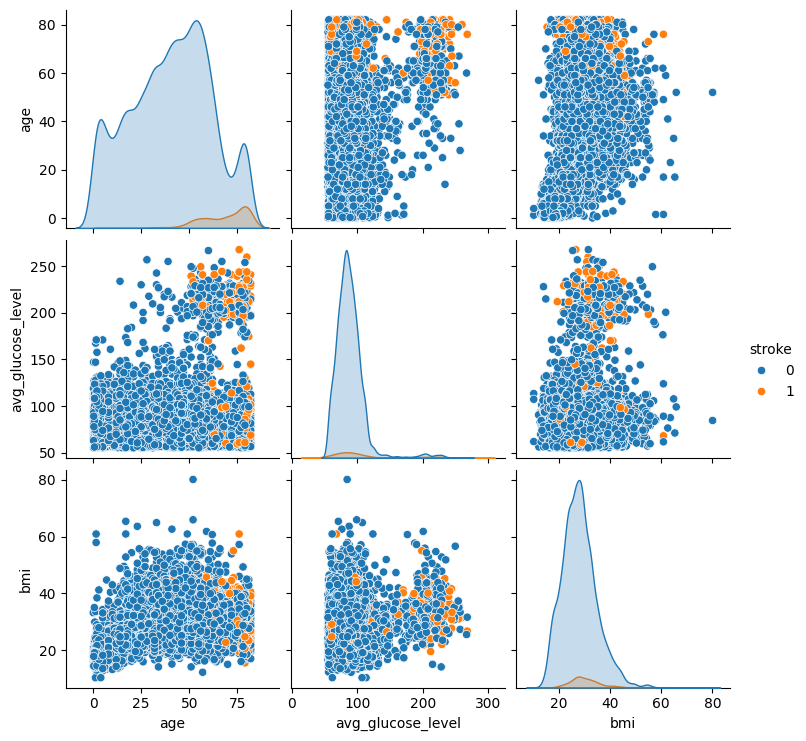

In [22]:
cols = num_vars + target_var
sns.pairplot(df.loc[:, cols], hue='stroke')

### 4.3 Discrete Variable

In [23]:
def plot_proportion(df: pd.DataFrame,
                    cols_group: list,
                    var_axis_name: str,
                    arrowhead_pos: float):

    prop = (df
            .groupby(cols_group)
            .gender
            .count()
            .unstack())
    
    print(prop)
    
    prop = prop.div(prop.sum(axis=1), axis=0)

  

    categories = prop[0].index

    fix, ax = plt.subplots()
    prop.plot.barh(stacked='True',
                   title=f'Proportion of {var_axis_name} type and stroke status',
                   xlabel='Percentage',
                   ylabel=var_axis_name,
                   ax=ax)
    
    for idx, cat in enumerate(categories):
        cat_stroke_perc = str(round(prop[1][cat], 2)*100) + '%'
        ax.annotate(cat_stroke_perc, xy=(arrowhead_pos, idx), xytext=(0.5, idx+0.3), arrowprops=dict(facecolor='black', shrink=0.05))
        

    plt.show()

Based on the plot below, people with hypertension are more likely to develop stroke

stroke            0    1
hypertension            
0             14039  504
1               633  128


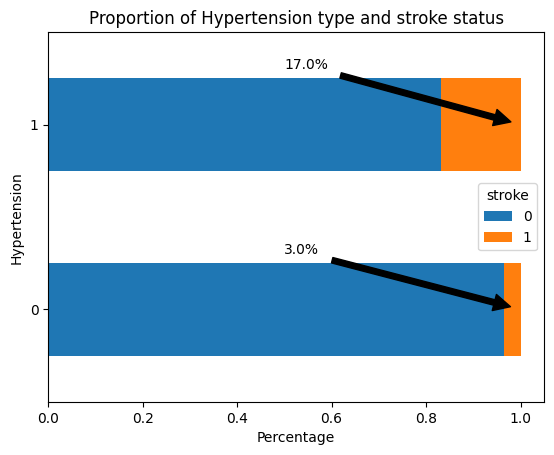

In [24]:
plot_proportion(df=df,
                cols_group=['hypertension', 'stroke'],
                var_axis_name='Hypertension',
                arrowhead_pos=1.0)

Based on the plot below, people with heart disease are more likely to develop stroke

stroke             0    1
heart_disease            
0              14381  566
1                291   66


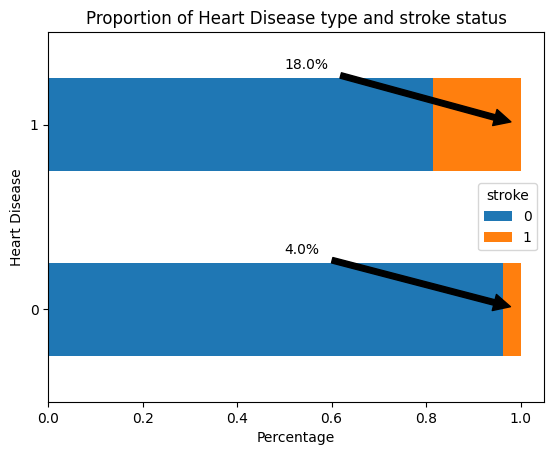

In [25]:
plot_proportion(df=df,
                cols_group=['heart_disease', 'stroke'],
                var_axis_name='Heart Disease',
                arrowhead_pos=1.0)

### 4.4 Categorical Variables

In [26]:
def check_cardinality(data, var):
    data = data.copy()

    # get cardinality
    num_unique = data[var].nunique()
    unique_labels = data[var].unique()

    print(f"Column: {var}\n Number of unique labels: {num_unique} \n Unique Labels: {unique_labels}")

For ``smoking_status``, we can group the ``formerly smoked`` status with ``smokes`` since they all represent people who have smoked before

In [27]:
for var in cat_vars:
    check_cardinality(df, var)

Column: gender
 Number of unique labels: 3 
 Unique Labels: ['Male' 'Female' 'Other']
Column: ever_married
 Number of unique labels: 2 
 Unique Labels: ['Yes' 'No']
Column: work_type
 Number of unique labels: 5 
 Unique Labels: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Column: Residence_type
 Number of unique labels: 2 
 Unique Labels: ['Urban' 'Rural']
Column: smoking_status
 Number of unique labels: 4 
 Unique Labels: ['never smoked' 'formerly smoked' 'Unknown' 'smokes']


- There is only 1 observation whose ``gender`` is stated as "Other". We could remove this observation since the cardinality is not large enough to help with prediction.
- From the proportion plot, it seems like gender does not really matter in whether someone develops stroke or not.

stroke       0      1
gender               
Female  9078.0  368.0
Male    5593.0  264.0
Other      1.0    NaN


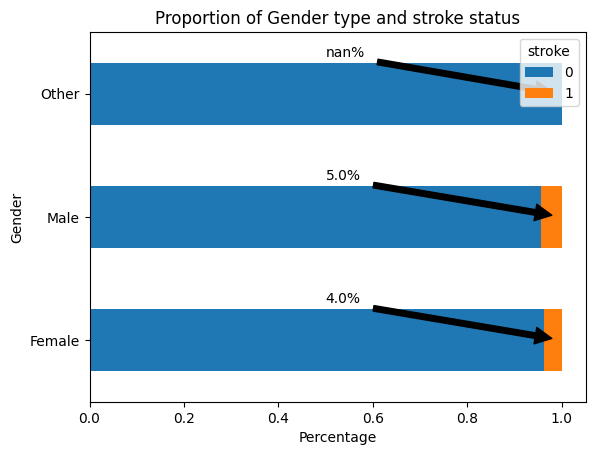

In [28]:
plot_proportion(df=df,
                cols_group=['gender', 'stroke'],
                var_axis_name='Gender',
                arrowhead_pos=1.0)

- People who are married have higher chance of developing stroke. This is probably due to older age.

stroke           0    1
ever_married           
No            4878   41
Yes           9794  591


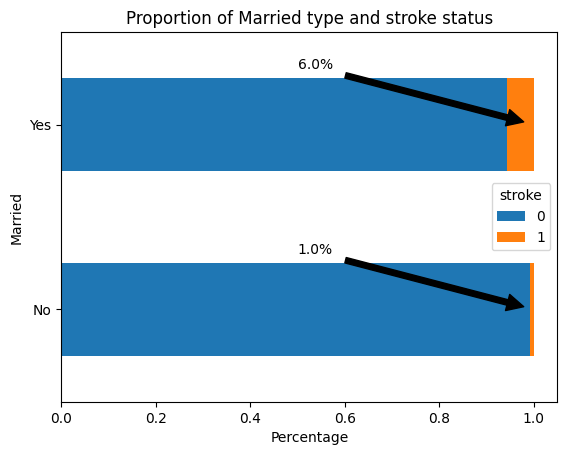

In [29]:
plot_proportion(df=df,
                cols_group=['ever_married', 'stroke'],
                var_axis_name='Married',
                arrowhead_pos=1.0)

<Axes: xlabel='ever_married', ylabel='age'>

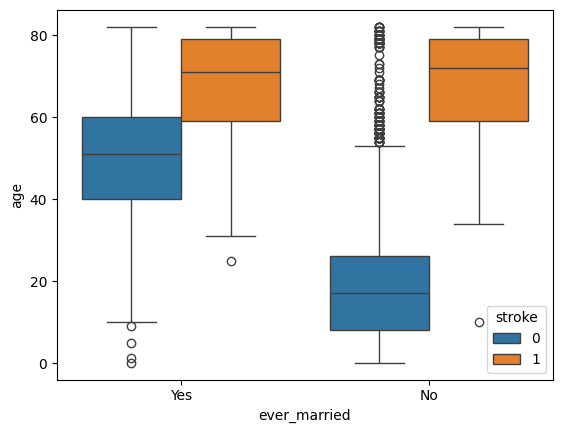

In [30]:
sns.boxplot(x="ever_married", y='age', data=df, hue='stroke')

- People who belongs to ``work_type == Never_worked`` and ``work_type == children`` are not likely to develop stroke. This could be due to age variable as well

stroke              0      1
work_type                   
Govt_job       1464.0   69.0
Never_worked     42.0    NaN
Private        9348.0  404.0
Self-employed  1781.0  158.0
children       2037.0    1.0


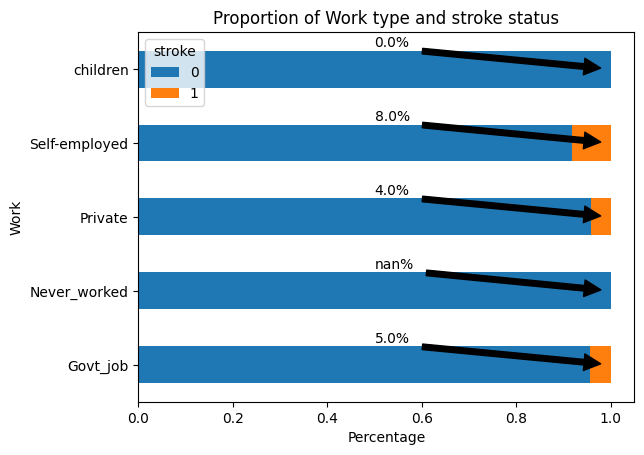

In [31]:
plot_proportion(df=df,
                cols_group=['work_type', 'stroke'],
                var_axis_name='Work',
                arrowhead_pos=1.0)

<Axes: xlabel='work_type', ylabel='age'>

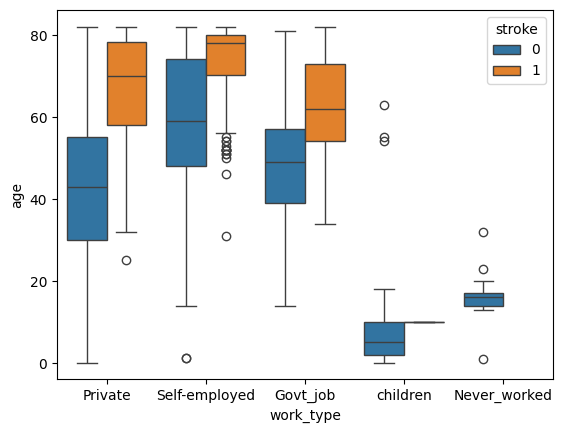

In [32]:
sns.boxplot(x="work_type", y="age", hue="stroke", data=df)

- The ``Residence_type`` does not matter at all in predicting stroke status

stroke             0    1
Residence_type           
Rural           7347  317
Urban           7325  315


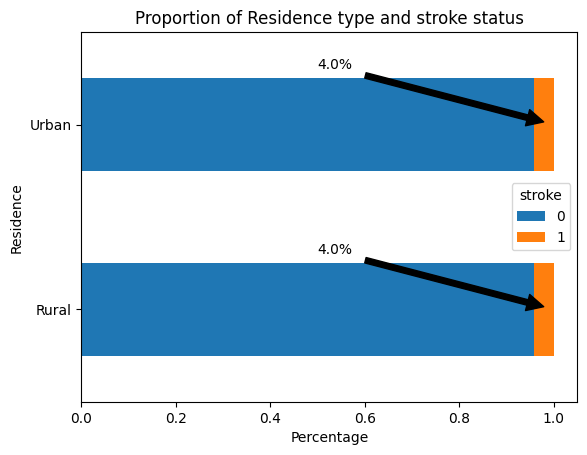

In [33]:
plot_proportion(df=df,
                cols_group=['Residence_type', 'stroke'],
                var_axis_name='Residence',
                arrowhead_pos=1.0)

As mentioned, we can group formerly smoked and smoke into one category since they represent people who has ever inhaled nicotine 

In [34]:
df_smoke = (df
            .copy()
            .assign(smoking_status=lambda df_: np.where(df_.smoking_status == 'formerly smoked', 'smokes', df_.smoking_status))
)

stroke              0    1
smoking_status            
Unknown          4435  108
formerly smoked  2178  159
never smoked     6024  257
smokes           2035  108


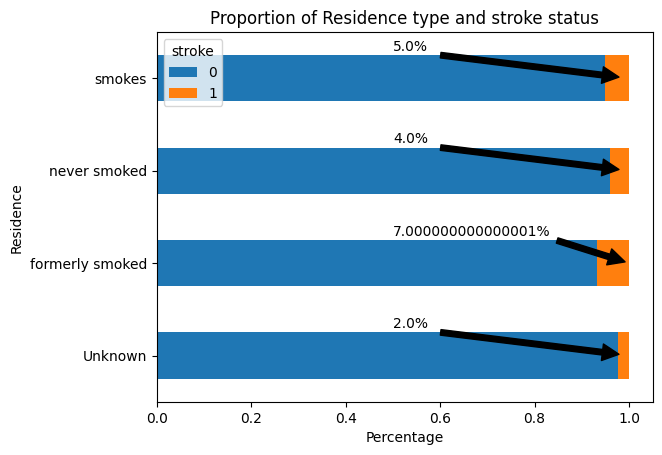

In [35]:
plot_proportion(df=df,
                cols_group=['smoking_status', 'stroke'],
                var_axis_name='Residence',
                arrowhead_pos=1.0)

- People whose ``smoking_status == smokes`` tend to be slightly more prone to developing stroke thought the impact is not significant

stroke             0    1
smoking_status           
Unknown         4435  108
never smoked    6024  257
smokes          4213  267


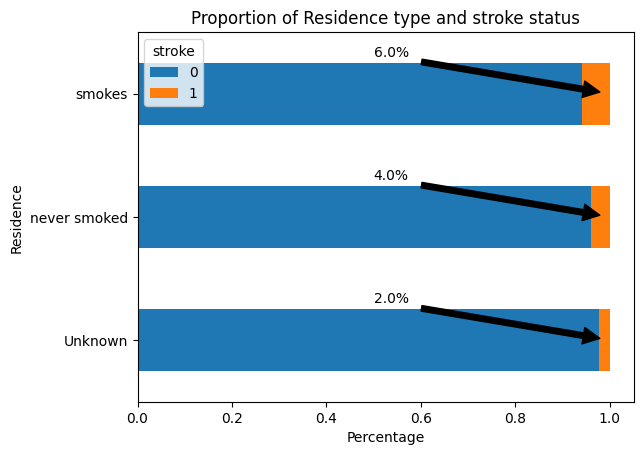

In [36]:
plot_proportion(df=df_smoke,
                cols_group=['smoking_status', 'stroke'],
                var_axis_name='Residence',
                arrowhead_pos=1.0)